In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
nba_players = pd.read_csv('./NBA_clean.csv', index_col=0)
nba_players = nba_players.sample(frac=1) #shuffle 100% of rows
nba_players = nba_players.reset_index(drop=True)
"""
nba_players = nba_players.drop(['MIN', 'Age', 'Weight', 'BMI', 'OREB', 'DREB', 'FTM',  'FTA', 'FT%', 'TOV', 'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'FGM', 'FGA', '3PM', '3PA'], axis=1)
for stat in nba_players:
    print(stat)
nba_players = nba_players.reset_index(drop=True)
#nba_players
"""

"\nnba_players = nba_players.drop(['MIN', 'Age', 'Weight', 'BMI', 'OREB', 'DREB', 'FTM',  'FTA', 'FT%', 'TOV', 'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'FGM', 'FGA', '3PM', '3PA'], axis=1)\nfor stat in nba_players:\n    print(stat)\nnba_players = nba_players.reset_index(drop=True)\n#nba_players\n"

In [4]:
def normalize(nba_players):
    nbamean = np.mean(nba_players.loc[:, nba_players.columns != 'Pos'], axis = 0)
    nba_players = nba_players - nbamean
    nbastd = np.std(nba_players.loc[:, nba_players.columns != 'Pos'], axis = 0)
    nba_players = nba_players / nbastd
    #for stat in nba_players.loc[:, nba_players.columns != 'Pos']:
    #    nba_players[stat] = nba_players[stat] - np.mean(nba_players[stat])
    #for stat in nba_players.loc[:, nba_players.columns != 'Pos']:
    #    nba_players[stat] = nba_players[stat]/np.std(nba_players[stat])
    return nba_players, nbamean, nbastd

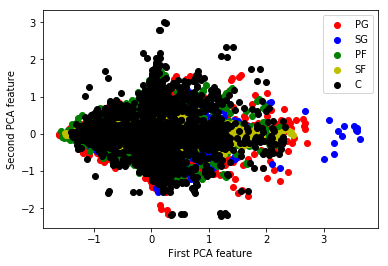

In [5]:
normalized_data,_,_ = normalize(nba_players.loc[:, nba_players.columns != 'Pos'])

f = normalized_data.loc[:, normalized_data.columns != 'Pos']
U,S,Vh = np.linalg.svd(f.T, full_matrices=True)

Uhat = U[:,0][:,None]
PC1 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T
Uhat = U[:,1][:,None]
PC2 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T

idx1 = np.where(nba_players['Pos'] == 'PG')[0]
idx2 = np.where(nba_players['Pos'] == 'SG')[0]
idx3 = np.where(nba_players['Pos'] == 'PF')[0]
idx4 = np.where(nba_players['Pos'] == 'SF')[0]
idx5 = np.where(nba_players['Pos'] == 'C')[0]

plt.scatter(PC1[idx1], PC2[idx1], c='r')
plt.scatter(PC1[idx2], PC2[idx2], c='b')
plt.scatter(PC1[idx3], PC2[idx3], c='g')
plt.scatter(PC1[idx4], PC2[idx4], c='y')
plt.scatter(PC1[idx5], PC2[idx5], c='k')
plt.legend(['PG', 'SG', 'PF', 'SF', 'C'])
plt.xlabel('First PCA feature')
plt.ylabel('Second PCA feature')
plt.show()


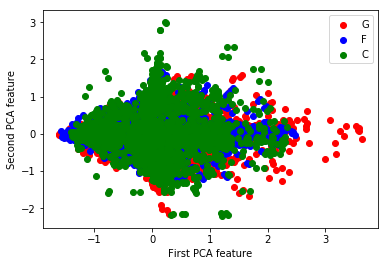

In [6]:
labels = nba_players.loc[:, 'Pos']
genpos = []
for a in labels:
    genpos.append(a[-1])
generalized_nba_players = nba_players.loc[:, nba_players.columns != 'Pos']
generalized_nba_players['Pos'] = genpos

normalized_data,_,_ = normalize(generalized_nba_players.loc[:, generalized_nba_players.columns != 'Pos'])

f = normalized_data.loc[:, normalized_data.columns != 'Pos']
U,S,Vh = np.linalg.svd(f.T, full_matrices=True)

Uhat = U[:,0][:,None]
PC1 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T
Uhat = U[:,1][:,None]
PC2 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T

idx1 = np.where(generalized_nba_players['Pos'] == 'G')[0]
idx2 = np.where(generalized_nba_players['Pos'] == 'F')[0]
idx3 = np.where(generalized_nba_players['Pos'] == 'C')[0]

plt.scatter(PC1[idx1], PC2[idx1], c='r')
plt.scatter(PC1[idx2], PC2[idx2], c='b')
plt.scatter(PC1[idx3], PC2[idx3], c='g')
plt.legend(['G', 'F', 'C'])
plt.xlabel('First PCA feature')
plt.ylabel('Second PCA feature')
plt.show()

In [7]:
validation_data  = nba_players.loc[360:421, nba_players.columns != 'Pos']
validation_labels = nba_players.loc[360:421, 'Pos']

gen_validation_data  = generalized_nba_players.loc[360:421, generalized_nba_players.columns != 'Pos']
gen_validation_labels = generalized_nba_players.loc[360:421, 'Pos']

In [8]:
splits = [0, 60 - 1, 120 - 1, 180 - 1, 240 - 1, 300 - 1, 360 - 1]

def cross_validation(nba_players, KNN, n=5):
    p = []
    pos_labels=["PG", "SG", "C", "PF", "SF"]
    if n == 3:
        pos_labels = ["G", "C", "F"]
    confusion_mat = np.zeros((n, n))
    for i in range(len(splits) - 1):
        #print(i)
        s1 = training_data = nba_players.loc[0:splits[i]-1, nba_players.columns != 'Pos']
        s2 = training_data = nba_players.loc[splits[i+1]+1:359, nba_players.columns != 'Pos']
        l1 = training_data = nba_players.loc[0:splits[i]-1, 'Pos']
        l2 = training_data = nba_players.loc[splits[i+1]+1:359,  'Pos']
        training_data = pd.concat([s1, s2])
        training_labels = pd.concat([l1, l2])
        testing_data = nba_players.loc[splits[i]:splits[i+1], nba_players.columns != 'Pos']
        testing_labels = nba_players.loc[splits[i]:splits[i+1], 'Pos']
        training_data = training_data.reset_index(drop=True)
        testing_data = testing_data.reset_index(drop=True)

        #testing_data = normalize(testing_data)
        training_data, tmean, tstd = normalize(training_data)
        U,S,Vh = np.linalg.svd(training_data.T, full_matrices=True)
        totalerr = np.linalg.norm(S,2)**2
        currenterr = 0
        idx = 0
        while currenterr < 0.95*totalerr:
            currenterr+=S[idx]**2
            idx+=1
        Uhat = U[:,:idx]
        training_data = np.matmul(Uhat, np.matmul(Uhat.T, training_data.T)).T
        testing_data = (testing_data - tmean)/tstd
        testing_data = np.matmul(Uhat, np.matmul(Uhat.T, testing_data.T)).T

        KNN.fit(training_data, training_labels)
        pred = KNN.predict(testing_data)
        conf_mat = confusion_matrix(testing_labels, pred, labels = pos_labels)
        acc = KNN.score(testing_data, testing_labels)
        p.append(acc)
        confusion_mat += conf_mat
        print('Fold', i)
        print(conf_mat)
    confusion_mat /= 6
    print("Final confusion matrix:")
    print(confusion_mat)
    return np.mean(p)
#KNN3 = KNeighborsClassifier(n_neighbors=3)
#KNN3.fit(nba_players.loc[0:359, nba_players.columns != 'Pos'], nba_players.loc[0:359, 'Pos'])

In [9]:
klist = [4,5,6,7,8,9,10,11,12]
perf = []
for k in klist:
    KNN = KNeighborsClassifier(n_neighbors=k)
    perf.append(cross_validation(nba_players, KNN, 5))
print(perf)

Fold 0
[[11  1  0  0  0]
 [ 4  5  0  0  3]
 [ 0  0  6  2  1]
 [ 0  0  6  7  4]
 [ 0  3  0  1  6]]
Fold 1
[[ 9  0  0  0  0]
 [ 2 12  0  0  2]
 [ 0  0  3  4  0]
 [ 0  0  4 10  1]
 [ 0  6  1  1  6]]
Fold 2
[[16  4  0  0  0]
 [ 3  3  0  0  4]
 [ 0  0  6  0  2]
 [ 0  0  4  9  1]
 [ 0  1  0  1  7]]
Fold 3
[[12  4  0  0  0]
 [ 4  9  0  0  2]
 [ 0  0  9  3  0]
 [ 0  0  2  4  1]
 [ 0  3  1  1  6]]
Fold 4
[[13  0  0  0  0]
 [ 2  4  0  1  7]
 [ 0  0  9  3  0]
 [ 0  0  3  8  1]
 [ 1  3  0  2  4]]
Fold 5
[[ 8  1  0  0  0]
 [ 2  7  1  0  2]
 [ 0  0 11  3  0]
 [ 0  2  4  7  1]
 [ 1  4  0  0  7]]
Final confusion matrix:
[[11.5         1.66666667  0.          0.          0.        ]
 [ 2.83333333  6.66666667  0.16666667  0.16666667  3.33333333]
 [ 0.          0.          7.33333333  2.5         0.5       ]
 [ 0.          0.33333333  3.83333333  7.5         1.5       ]
 [ 0.33333333  3.33333333  0.33333333  1.          6.        ]]
Fold 0
[[9 3 0 0 0]
 [2 6 0 2 2]
 [0 0 5 3 1]
 [0 0 6 5 6]
 [0 2 0 2 6]]

In [10]:
#validate
def validateKNN(nba_players, validation_data, validation_labels, classifier, n=3):
    pos_labels = ["G", "C", "F"]
    if n == 5:
        pos_labels=["PG", "SG", "C", "PF", "SF"]
#     print(klist[np.argmax(perf)])
#     KNN = KNeighborsClassifier(n_neighbors=klist[np.argmin(perf)])
    training_data = nba_players.loc[0:359, nba_players.columns != 'Pos']
    training_labels = nba_players.loc[0:359, 'Pos']
    training_data = training_data.reset_index(drop=True)
    training_data, tmean, tstd = normalize(training_data)
    U,S,Vh = np.linalg.svd(training_data.T, full_matrices=True)
    totalerr = np.linalg.norm(S,2)**2
    currenterr = 0
    idx = 0
    while currenterr < 0.95*totalerr:
        currenterr+=S[idx]**2
        idx+=1
    Uhat = U[:,:idx]
    training_data = np.matmul(Uhat, np.matmul(Uhat.T, training_data.T)).T

    classifier.fit(training_data, training_labels)
    #validation_data = normalize(validation_data)
    validation_data = (validation_data - tmean)/tstd
    validation_data = np.matmul(Uhat, np.matmul(Uhat.T, validation_data.T)).T
    acc = classifier.score(validation_data, validation_labels)
    pred = classifier.predict(validation_data)
    print('Confusion matrix:')
    print(confusion_matrix(validation_labels, pred, labels = pos_labels))
    print(acc)
    print()
    return acc

In [11]:
validateKNN(nba_players, validation_data, validation_labels, KNeighborsClassifier(n_neighbors=klist[np.argmin(perf)]),5)

Confusion matrix:
[[ 7  0  0  0  0]
 [ 3 14  1  1  2]
 [ 0  0  5  6  0]
 [ 0  0  0  6  5]
 [ 1  4  0  2  5]]
0.5967741935483871



0.5967741935483871

In [12]:
klist = [4,5,6,7,8,9,10,11,12]
perf = []
for k in klist:
    KNN = KNeighborsClassifier(n_neighbors=k)
    perf.append(cross_validation(generalized_nba_players, KNN, 3))
print(perf)

Fold 0
[[19  0  5]
 [ 0  6  3]
 [ 3  5 19]]
Fold 1
[[23  0  2]
 [ 0  3  4]
 [ 5  5 19]]
Fold 2
[[25  0  5]
 [ 0  6  2]
 [ 1  4 18]]
Fold 3
[[27  0  4]
 [ 0  9  3]
 [ 2  2 14]]
Fold 4
[[19  0  8]
 [ 0  9  3]
 [ 2  3 17]]
Fold 5
[[18  0  3]
 [ 0 11  3]
 [ 5  4 17]]
Final confusion matrix:
[[21.83333333  0.          4.5       ]
 [ 0.          7.33333333  3.        ]
 [ 3.          3.83333333 17.33333333]]
Fold 0
[[20  0  4]
 [ 0  5  4]
 [ 2  5 20]]
Fold 1
[[23  0  2]
 [ 0  3  4]
 [ 5  3 21]]
Fold 2
[[30  0  0]
 [ 0  6  2]
 [ 2  4 17]]
Fold 3
[[28  0  3]
 [ 0  8  4]
 [ 2  3 13]]
Fold 4
[[25  0  2]
 [ 0  7  5]
 [ 2  0 20]]
Fold 5
[[19  0  2]
 [ 0  9  5]
 [ 6  3 17]]
Final confusion matrix:
[[24.16666667  0.          2.16666667]
 [ 0.          6.33333333  4.        ]
 [ 3.16666667  3.         18.        ]]
Fold 0
[[20  0  4]
 [ 0  6  3]
 [ 2  6 19]]
Fold 1
[[22  0  3]
 [ 0  4  3]
 [ 3  7 19]]
Fold 2
[[28  0  2]
 [ 0  6  2]
 [ 1  3 19]]
Fold 3
[[27  0  4]
 [ 0  9  3]
 [ 1  3 14]]
Fold 4
[[22 

In [13]:
validateKNN(generalized_nba_players, gen_validation_data, gen_validation_labels, KNeighborsClassifier(n_neighbors=klist[np.argmin(perf)]))

Confusion matrix:
[[21  1  6]
 [ 0  5  6]
 [ 2  1 20]]
0.7419354838709677



0.7419354838709677

# Decision Tree Classifier

In [18]:
depths = [1,2, 3, 4, 5]
samples = [0.02, 0.05, 0.1, 0.2, 1]
#parameter variations for cross validation
perf = []
best = 0
opt = (0, 0)
for m in depths:
    for s in samples:
        DT = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        perf.append(cross_validation(generalized_nba_players, DT, 3))
        if perf[-1] > best:
            best = perf[-1]
            opt = (m, s)
        print('Performance was {:.3f} with depth={} and samples={}'.format(perf[-1], m, s))
    print()
print('Optimal performance was {:.3f} with depth={} and samples={}'.format(best, *opt))

Fold 0
[[23  0  1]
 [ 1  0  8]
 [ 1  0 26]]
Fold 1
[[24  0  1]
 [ 0  0  7]
 [ 0  0 29]]
Fold 2
[[28  0  2]
 [ 0  0  8]
 [ 1  0 22]]
Fold 3
[[27  0  4]
 [ 0  0 12]
 [ 0  0 18]]
Fold 4
[[24  0  3]
 [ 0  0 12]
 [ 0  0 22]]
Fold 5
[[20  0  1]
 [ 0  0 14]
 [ 2  0 24]]
Final confusion matrix:
[[24.33333333  0.          2.        ]
 [ 0.16666667  0.         10.16666667]
 [ 0.66666667  0.         23.5       ]]
Performance was 0.786 with depth=1 and samples=0.02
Fold 0
[[23  0  1]
 [ 1  0  8]
 [ 1  0 26]]
Fold 1
[[24  0  1]
 [ 0  0  7]
 [ 0  0 29]]
Fold 2
[[28  0  2]
 [ 0  0  8]
 [ 1  0 22]]
Fold 3
[[27  0  4]
 [ 0  0 12]
 [ 0  0 18]]
Fold 4
[[24  0  3]
 [ 0  0 12]
 [ 0  0 22]]
Fold 5
[[20  0  1]
 [ 0  0 14]
 [ 2  0 24]]
Final confusion matrix:
[[24.33333333  0.          2.        ]
 [ 0.16666667  0.         10.16666667]
 [ 0.66666667  0.         23.5       ]]
Performance was 0.786 with depth=1 and samples=0.05
Fold 0
[[23  0  1]
 [ 1  0  8]
 [ 1  0 26]]
Fold 1
[[24  0  1]
 [ 0  0  7]
 [ 0  0 2

Fold 1
[[24  0  1]
 [ 0  7  0]
 [ 0  4 25]]
Fold 2
[[28  0  2]
 [ 0  8  0]
 [ 1  4 18]]
Fold 3
[[27  0  4]
 [ 0  7  5]
 [ 0  2 16]]
Fold 4
[[24  0  3]
 [ 0  9  3]
 [ 0  4 18]]
Fold 5
[[20  0  1]
 [ 0 10  4]
 [ 2  5 19]]
Final confusion matrix:
[[24.33333333  0.          2.        ]
 [ 0.16666667  7.83333333  2.33333333]
 [ 0.66666667  3.83333333 19.66666667]]
Performance was 0.852 with depth=4 and samples=0.2
Fold 0
[[23  0  1]
 [ 0  5  4]
 [ 1  2 24]]
Fold 1
[[23  0  2]
 [ 0  4  3]
 [ 0  3 26]]
Fold 2
[[27  0  3]
 [ 0  7  1]
 [ 1  2 20]]
Fold 3
[[29  0  2]
 [ 0  6  6]
 [ 1  0 17]]
Fold 4
[[24  0  3]
 [ 0  9  3]
 [ 0  2 20]]
Fold 5
[[20  0  1]
 [ 0 10  4]
 [ 6  3 17]]
Final confusion matrix:
[[24.33333333  0.          2.        ]
 [ 0.          6.83333333  3.5       ]
 [ 1.5         2.         20.66666667]]
Performance was 0.852 with depth=4 and samples=1

Fold 0
[[23  0  1]
 [ 1  5  3]
 [ 1  5 21]]
Fold 1
[[24  0  1]
 [ 0  4  3]
 [ 0  6 23]]
Fold 2
[[28  0  2]
 [ 0  7  1]
 [ 1  4 18]]

In [15]:
optTree = DecisionTreeClassifier(max_depth=opt[0], min_samples_leaf=opt[1])
optPerf = validateKNN(generalized_nba_players, gen_validation_data, gen_validation_labels, optTree)

print('The performance on the validation data is {:.3f}'.format(optPerf))


Confusion matrix:
[[20  2  6]
 [ 0  8  3]
 [ 0  5 18]]
0.7419354838709677

The performance on the validation data is 0.742


### QDA

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold

### Stratified cross validation and QDA

In [17]:
data = nba_players.loc[:, nba_players.columns != 'Pos']
label_map = {'PG':0, 'SG':1, 'PF':2, 'SF':3, 'C':4}
labels = np.array([label_map[pos] for pos in nba_players['Pos']])


for run_pca in (True, False):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    accuracy = 0
    for i, (train_indices, test_indices) in enumerate(skf.split(data, labels)):

        train_data = nba_players.loc[train_indices, nba_players.columns != 'Pos']
        test_data = nba_players.loc[test_indices, nba_players.columns != 'Pos']
        
        if run_pca:
            train_data, tmean, tstd = normalize(train_data)
            U,S,Vh = np.linalg.svd(train_data.T, full_matrices=True)
            totalerr = np.linalg.norm(S, 2)**2
            currenterr = 0
            idx = 0
            while currenterr < 0.95*totalerr:
                currenterr+=S[idx]**2
                idx+=1
            Uhat = U[:,:idx]
            train_data = np.matmul(Uhat, np.matmul(Uhat.T, train_data.T)).T
            test_data = (test_data - tmean)/tstd
            test_data = np.matmul(Uhat, np.matmul(Uhat.T, test_data.T)).T

        qda = QuadraticDiscriminantAnalysis(store_covariance=True)
        qda.fit(train_data, labels[train_indices])
        acc = qda.score(test_data, labels[test_indices])
        print('Fold', i, acc)
        accuracy += acc
    accuracy /= 5
    print('Accuracy ' + ('with PCA ' if run_pca else '') + str(accuracy))
    print()

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Fold 0 0.5
Fold 1 0.6705882352941176
Fold 2 0.6547619047619048
Fold 3 0.6309523809523809
Fold 4 0.6626506024096386
Accuracy with PCA 0.6237906246836082

Fold 0 0.7209302325581395
Fold 1 0.6941176470588235
Fold 2 0.6190476190476191
Fold 3 0.6428571428571429
Fold 4 0.7228915662650602
Accuracy 0.679968841557357



Though some of the variables in the raw features are collinear, the raw features have better performance than the top 95% of PCA features.